In [587]:
import pandas as pd
import numpy as np
from statsmodels.tsa.filters.hp_filter import hpfilter
import matplotlib.pyplot as plt
import statsmodels.api as sm
import datetime as dt
import seaborn as sns
import os
from sklearn.model_selection import train_test_split
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model._ridge import Ridge
from keras.metrics import mean_absolute_percentage_error, mean_squared_error


In this notebook, I will explore the difference between applying regression model (Kernel ridge regression) using different sets of data : a raw data (closing price of stocks daily), and a preprocessed smoothed data (closing price of stocks w/ HP-Filter applied). For the sake of comparison, I will be using two different assets, which are TESLA and US Treasury bond. 

In [337]:
days = 250 # This parameter sets different number of days we are going to use for our time lag

We apply timelag to our data in order to generate more data from a single source. This technique is commonly used in time series analysis.

In [589]:

def produceHP(ticker):
    ticker = "\\Data\\{}".format(ticker) + ".csv"
    dir = os.getcwd() + ticker
    data = pd.read_csv(dir)
    data = data.set_index('Date')
    x = data.index
    x = [dt.datetime.strptime(d, '%Y-%m-%d') for d in x]
    price = data['Close']
    cycle, trend = sm.tsa.filters.hpfilter(price, 1000000)
    y = trend
    plt.plot(x, y)
    y = price
    plt.plot(x, y)
    plt.show()
    return (data, trend)
def reshape_data(df):
    data_reshape = pd.concat([df['Close'].T.shift(i).to_frame().stack(dropna=False) for i in range(days) ], 1).dropna()
    data_reshape.columns = pd.Index(range(days), name='timeLag')
    return data_reshape

First, we apply HP-filter to a data and see what it does in order to understand it. Then, we apply time lag to the raw data.

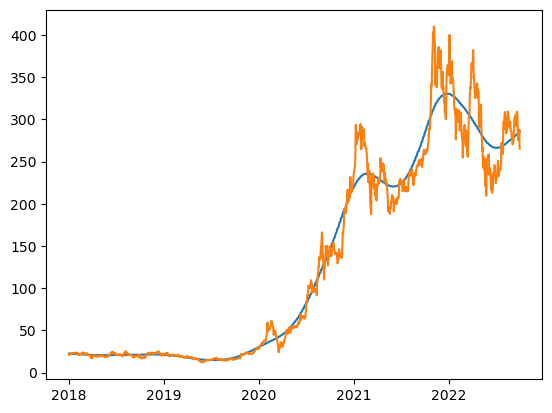

C:\Users\18hli\AppData\Local\Temp\ipykernel_44684\1221316311.py:17: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  data_reshape = pd.concat([df['Close'].T.shift(i).to_frame().stack(dropna=False) for i in range(days) ], 1).dropna()


In [590]:
data, trend = produceHP("TSLA")
data_reshape = reshape_data(data)

We define a split method in order to set some of the data as test set, and some as training set.

In [594]:
def split(data):
    X = data[np.arange(1, days)]
    y = data[0]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)
    return (X_train, X_test, y_train, y_test)

Then, we apply time lag onto HP-Filter too.

In [593]:
def get_HP_lag(data_reshape):
    trend_data = pd.DataFrame()
    # trend_data.columns = pd.Index(range(50), name='timeLag')
    rows = []
    for i in range(len(data_reshape)):
        row = data_reshape.iloc[i]
        cycle, trend = sm.tsa.filters.hpfilter(row[1:], 100000)
        rows.append(pd.concat([pd.Series(row[0]), trend], axis = 0))

    trend_data = pd.DataFrame(rows)
    trend_data.columns = pd.Index(range(days), name='timeLag')
    return trend_data

Since we now have all data that we need for comparison, we run kernel-ridge regression to test how the model performs. We decided to use this model since it supports non-linearity of the data. Hyperparameter, also known as a regularization factor can be adjusted accordingly. If regularization term is 0, it becomes a traditional least-square problem, while higher regularization factor underfits the model. Thus, there are two hyperparameters in our model : number of days used for prediction, and regularization factor alpha.

In [614]:
def test(data_reshape, reg):
    sum = 0.0
    for i in range(100):
        X_train, X_test, y_train, y_test = split(data_reshape)
        model = KernelRidge(alpha = reg)
        model.fit(X_train, y_train)
        prediction = model.predict(X_test)
        sum += mean_squared_error(prediction, y_test)
    print(prediction - y_test)
    return sum

In [596]:
ticker = "TSLA"
days = 250

In [615]:
def pipeline(t, d, a):
    ticker = t
    days = d
    data, trend = produceHP(ticker)
    data_reshape = reshape_data(data)
    trend_reshape = get_HP_lag(data_reshape)
    print(test(data_reshape, a))
    print(test(trend_reshape, a))

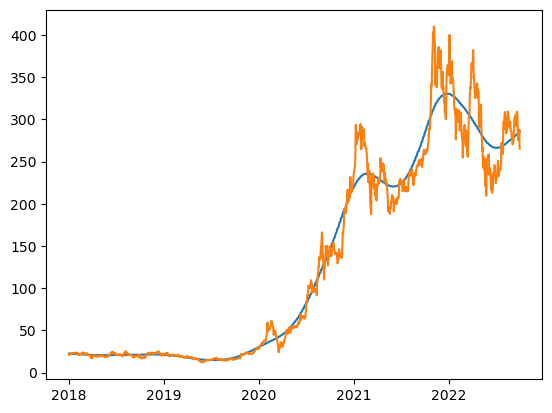

C:\Users\18hli\AppData\Local\Temp\ipykernel_44684\1221316311.py:17: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  data_reshape = pd.concat([df['Close'].T.shift(i).to_frame().stack(dropna=False) for i in range(days) ], 1).dropna()


Date             
2022-04-12  Close    24.757975
2019-03-15  Close    -0.132475
2022-07-12  Close    19.732881
2021-09-01  Close    -7.074995
2022-03-29  Close   -24.743757
                       ...    
2019-01-03  Close     2.969515
2020-10-08  Close    -4.496064
2020-08-25  Close    -2.626416
2019-06-07  Close     1.120750
2021-12-31  Close    40.381896
Name: 0, Length: 237, dtype: float64
tf.Tensor(18626.36878722829, shape=(), dtype=float64)
68      0.283785
341     1.002465
618     0.160752
752   -24.814650
813   -29.733677
         ...    
322    -3.949269
555   -11.622487
883     6.802258
183     0.568347
4      -0.362469
Name: 0, Length: 237, dtype: float64
tf.Tensor(11381.903412194832, shape=(), dtype=float64)


In [621]:
pipeline("TSLA", 250, 1)

As you can see, MSE for model using raw data was higher compared to its counterpart using smoothed data. 

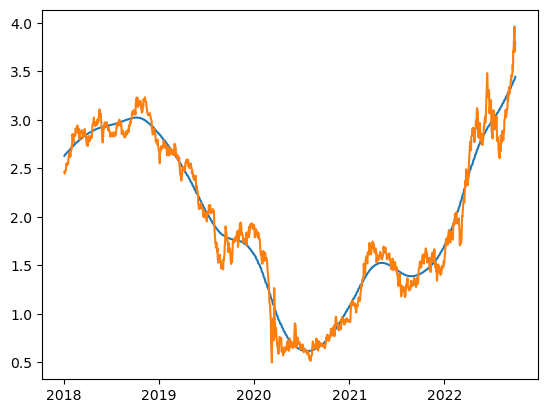

C:\Users\18hli\AppData\Local\Temp\ipykernel_44684\1221316311.py:17: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  data_reshape = pd.concat([df['Close'].T.shift(i).to_frame().stack(dropna=False) for i in range(days) ], 1).dropna()


Date             
2019-11-14  Close    0.058468
2019-10-23  Close   -0.016895
2021-08-18  Close    0.010559
2019-04-05  Close    0.015209
2021-01-04  Close   -0.033630
                       ...   
2019-04-10  Close    0.024677
2022-05-27  Close    0.013841
2021-01-14  Close   -0.009178
2022-08-23  Close   -0.039663
2020-06-04  Close   -0.106621
Name: 0, Length: 237, dtype: float64
tf.Tensor(0.3954314884607406, shape=(), dtype=float64)
44    -0.005477
54     0.065343
555   -0.038782
644    0.049905
139   -0.058308
         ...   
747   -0.033768
500    0.029503
198   -0.106866
212    0.089133
391   -0.021879
Name: 0, Length: 237, dtype: float64
tf.Tensor(1.2292567877327658, shape=(), dtype=float64)


In [620]:
pipeline("^TNX", 250, 1)

As you can see, for bonds, raw data performs better than the model using HP-Filter. 